# Introduction
Source: [World of Warcraft Avatar History Dataset](http://mmnet.iis.sinica.edu.tw/dl/wowah/)  
게임 시스템 디자이너의 관점에서 보면, 플레이어의 행동은 게임 시스템을 설계할 때 반드시 고려해야하는 가장 중요한 요소 중 하나입니다. 온라인 게이머들의 게임 내 행동에 대한 근본적인 이해를 얻기 위해서, 사용자의 게임 플레이 시간을 탐구하는 것은 좋은 출발점이 될 수 있습니다. <b>게임 플레이 시간</b> 개념은 MMORPG 뿐만아니라, 모든 장르의 게임에 적용이 가능하며, 시스템 작업뿐만 아니라 사용자 행덩에 대한 시스템 및 네트워크 QoS의 영향을 모델링할 수 있습니다. 또한 게임에 대한 유저들의 충성심을 예측하는 데 도움을 줄 수 있습니다.  

이 데이터는 91,056개의 캐릭터 기록으로 구성된 WoWAH(World of Warcraft Avatar History)입니다. 데이터의 관측기간은 월드 오브 워크래프트의 오리지날과 '불타는 성전과 리치왕의 분노'확장팩이 출시한 2006년 1월부터 2009년 1월까지 총 1,107일 입니다. 게임 내 캐릭터의 플레이 시간과 종족, 직업, 레벨 및 게임 내 위치와 같은 여러 속성이 제공됩니다.  

로그 추적에 대한 설명
관측기간 동안 모니터링한 91,065개의 캐릭터와 그 캐릭터와 관련된 667,032개의 세션이 관측되었습니다. 샘플링 주기는 10분이었습니다. 플레이어의 프라이버시를 보호하기 위해 캐릭터와 길드 이름은 일관된 매핑(동일한 이름이 항상 동일한 캐릭터로 매핑 됨)으로 이루어졌습니다. 데이터 셋의 요약은 Table 1에 제시되어 있습니다.  

![](http://mmnet.iis.sinica.edu.tw/dl/wowah/img/tbl_summary.jpg)

캐릭터 로그 파일은 Persistant_Storage 및 RoundInfo의 두 배열로 구성됩니다. 캐릭터 히스토리에 대해 수집 된 모든 데이터는 Persistant_Storage 배열에 저장됩니다. 각 요소는 샘플링 기간 동안 관찰 된 캐릭터에 대한 정보를 저장합니다. 따라서 요소의 수는 샘플링 기간동안 온라인 상태인 캐릭터의 수와 같습니다. 변수의 의미와 그에 대한 범위는 Table 2에 설명되어 있습니다. 또한 Table 3에는 3개의 샘플 행이 존재합니다. 첫 번째 행은 23:59:39에 ID 467인 캐릭터를 관측했음을 나타냅니다. 2006년 1월 1일에 이 캐릭터는 오그리마에 있는 레벨 1 오크 전사였습니다.

![](http://mmnet.iis.sinica.edu.tw/dl/wowah/img/tbl_fields.jpg)
![](http://mmnet.iis.sinica.edu.tw/dl/wowah/img/tbl_example.jpg)


# Import Module

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings 
warnings.filterwarnings('ignore')
print(os.listdir('./dataset'))

['locations.csv', 'location_coords.csv', 'wowah_data.csv', 'zones.csv']


# Preparing Dataset

## Define Function

In [2]:
## Function to reduce the DF size
## Source kernel: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
location = pd.read_csv('./dataset/locations.csv', encoding = 'unicode_escape')
location_coord = pd.read_csv('./dataset/location_coords.csv', encoding = 'unicode_escape')
wowah_data = pd.read_csv('./dataset/wowah_data.csv', encoding = 'unicode_escape')
wowah_data = reduce_mem_usage(wowah_data)
zones = pd.read_csv('./dataset/zones.csv', encoding = 'unicode_escape')

Mem. usage decreased to 402.68 Mb (30.4% reduction)


# Location

In [13]:
print('Number of Map_ID:', location.Map_ID.nunique())
print('Number of Location_Type:',location.Location_Type.nunique() )
print('Number of Location_Name:', location.Location_Name.nunique())
print('Number of Game_Version:', location.Game_Version.nunique())
location.head()

Number of Map_ID: 151
Number of Location_Type: 6
Number of Location_Name: 151
Number of Game_Version: 6


,Map_ID,Location_Type,Location_Name,Game_Version
0,0,Continent,Eastern Kingdoms,WoW
1,1,Continent,Kalimdor,WoW
2,530,Continent,Outlands,TBC
3,571,Continent,Northrend,WLK
4,646,Continent,Deepholm,CAT


Map_ID와 Location_Name의 고유값 개수가 같은 것으로 나타났습니다. 따라서 지역 이름별로 고유 ID가 매핑되어 있다는 것을 알 수 있습니다.  
지역 타입(Location_Type)은 다음과 같은 고유값을 가지고 있습니다.
- Continent: 대륙(일반적인 필드)
- Arena: 투기장
- Battleground: 전장
- Garrison: 대도시
- Dungeon: 던전
- Raid: 레이드 던전

게임 버전은 다음과 같은 고유값을 가지고 있습니다.
- WoW: 월드 오브 워크래프트 오리지날 (World of Warcraft)
- TBC: 월드 오브 워크래프트 불타는 성전 (World of Warcraft: The Burning Crusade)
- WLK: 월드 오브 워크래프트 리치왕의 분노 (World of Warcraft: Warth of Lich King)
- CAT: 월드 오브 워크래프트 대격변 (World of Warcraft: Cataclysm)
- MoP: 월드 오브 워크래프트 판다리아의 안개 (World of Warcraft: Mists of Pandaria)
- WoD: 월드 오브 워크래프트 드레노어의 전쟁군주 (World of Warcraft: Warlords of Draenor)

게임 버전을 확인해본 결과, 캐릭터에 대한 관측 기간에 벗어난 확장팩들이 존재한다는 것을 알 수 있습니다.

이제, 각 변수별로 어떤 값들이 가장 많은지 확인합니다. 

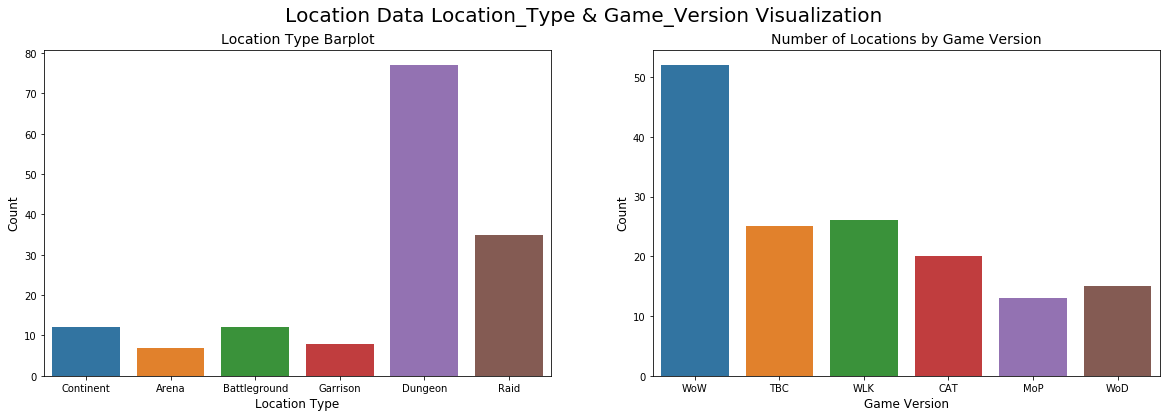

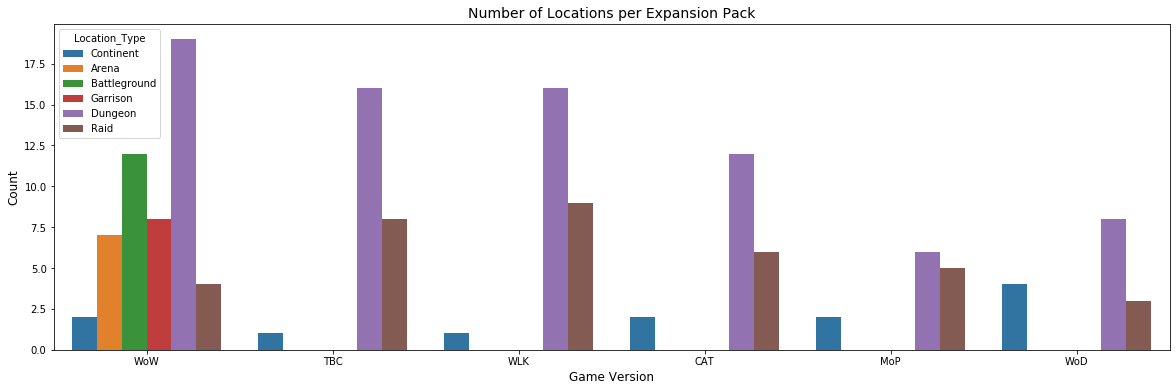

In [55]:
plt.figure(figsize = (20,6))

plt.suptitle('Location Data Location_Type & Game_Version Visualization', fontsize = 20)
plt.subplot(121)
sns.countplot(x = 'Location_Type', data = location)
plt.title('Location Type Barplot', fontsize = 14)
plt.xlabel('Location Type', fontsize =12)
plt.ylabel('Count', fontsize = 12)

plt.subplot(122)
sns.countplot(x = 'Game_Version', data = location)
plt.title('Number of Locations by Game Version', fontsize = 14)
plt.xlabel('Game Version', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.figure(figsize = (20,6))
sns.countplot(hue = 'Location_Type', x = 'Game_Version', data = location)
plt.title('Number of Locations per Expansion Pack', fontsize = 14)
plt.xlabel('Game Version', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.show()

지역 종류(Location_Type)은 던전(Dungeon)이 가장 많았고 그 뒤를 레이드 던전(Raid)이 이었습니다. 이는 매 확장팩마다 던전과 레이드 던전이 가장 많이 추가됐기 때문이라는 것을 확인했습니다.  
월드 오브 워크래프트 오리지날(WoW)에서 가장 많은 지역의 개수가 나타났는데, 이는 투기장(Arena), 전장(Battleground), 대도시(Garrison)이 새롭게 만들어졌기 때문입니다. 나머지 확장팩에서는 데이터 상으로 새롭게 만들어지지 않았습니다.


In [5]:
wowah_data.head()

,char,level,race,charclass,zone,guild,timestamp
0,59425,1,Orc,Rogue,Orgrimmar,165,01/01/08 00:02:04
1,65494,9,Orc,Hunter,Durotar,-1,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,-1,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,-1,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09


In [6]:
location_coord.head()

,Location_Name,Map_ID,X_coord,Y_coord,Z_coord
0,Eastern Kingdom: Ironforge Airport,0.0,-4488.993311,-1580.19104,509.005066
1,Eastern Kingdom: Wetlands Mountain Camp,0.0,-3855.000000,-3479.00000,579.000000
2,Eastern Kingdom: Dun Morogh plane camp,0.0,-6161.000000,-786.00000,423.000000
3,Eastern Kingdom: Undercity,0.0,1831.260000,238.53000,60.520000
4,Eastern Kingdom: Stormwind City,0.0,-8913.230000,554.63300,93.794400


In [7]:
zones.head()

,Zone_Name,Continent,Area,Zone,Subzone,Type,Size,Controlled,Min_req_level,Min_rec_level,Max_rec_level,Min_bot_level,Max_bot_level
0,Durotar,Kalimdor,Central Kalimdor,Durotar,NaN,Zone,NaN,Horde,1,1.0,10.0,1.0,10.0
1,The Barrens,Kalimdor,Central Kalimdor,The Barrens,NaN,Zone,NaN,Contested,1,10.0,35.0,10.0,35.0
2,Silverpine Forest,Eastern Kingdoms,Lordaeron,Silverpine Forest,NaN,Zone,NaN,Horde,1,10.0,20.0,10.0,20.0
3,Stonetalon Mountains,Kalimdor,Central Kalimdor,Stonetalon Mountains,NaN,Zone,NaN,Contested,1,25.0,30.0,25.0,30.0
4,Thunder Bluff,Kalimdor,Central Kalimdor,Thunder Bluff,NaN,City,NaN,Horde,1,1.0,100.0,1.0,100.0
